# DATA COLLECTION, CLEAN-UP AND ANALYSIS:
## THE MOST VANILLA SUPER HERO EVER
*By: Claudio Davi*

**Who is the most vanilla super hero ever? Can we create one?**

I asked myself this question the other day and decided to test some of my skills with data. In this notebook, I'll guide you throughout my thinking process during the pursuit of the answer.

## Imports

Those are the libraries used to make this happen.

In [2]:
from bs4 import BeautifulSoup
import urllib3
import pandas as pd
from collections import defaultdict

## Web Scraping

First, I had to find a website that cointained all the information I needed for this project. Looking around for data I got lucky finding on Kaggle.com two datasets with all the Marvel and DC character appearances. So I only had to scrape for powers.

On superherodb.com I've found a very thorough list with every super hero ever, and their respective powers. So I built a web scraper to get that data.

In [34]:
http = urllib3.PoolManager()
url = "http://www.superherodb.com"

def get_data(http, link):
    '''
    Gets the main power page from superhero db
    returns Beautifulsoup object
    '''
    wiki = http.request('GET', link)
    data = BeautifulSoup(wiki.data, 'html.parser')
    return data

def get_hero_links(data):
    herolinks = []
    
    for link in data.find_all("li", {"class": "char-li"}):
        for hero in link.find_all('a'):
            herolinks.append(url + hero["href"]) 
    return herolinks


def get_hero_characteristics(hero_links):
    #should return a list of heroes characteristics
    hero_dicts = []
    for hero_link in hero_links:
        d = {}
        data = get_data(http, hero_link)
        hero_name = data.find('h1').get_text()
        tr = data.find_all('tr')
        d['name'] = hero_name
        for table in tr: 
            td = table.find_all('td')
            d[td[0].get_text()] = td[1].get_text()
        hero_dicts.append(d)
    return hero_dicts

def get_power_links(data):
    '''
    gets the web site links for all powers
    returns a list of links
    '''
    powerlinks = []
    for link in data.find_all('a'):
        if "/powers/" in link.get('href'):
            powerlinks.append(url + link["href"])
    return powerlinks

def get_superhero_powers(links):
    '''
    from all links received scrape that page for the power name
    and add to a dict with lists as values.
    returns the dictionary
    '''
    powers = defaultdict(list)
    for link in links[1:]:
        data = get_data(http, link)
        power_name = data.find('h1').get_text()
        for hero_name in data.find_all("span", {"class": "card2-title"}):
            powers[hero_name.get_text()].append(power_name)
    return powers

def transform_data_into_csv(super_hero_powers, csv_name):
    '''
    from the dictionary created with the web scraper we create a dataframe and save it to
    csv
    '''
    df = pd.DataFrame(dict([ (hero,pd.Series(power)) for hero,power in super_hero_powers.items() ]))
    df.to_csv(csv_name)

## This is probably going to take a while, so we will save everything into csv files

In [ ]:
data = get_data(http,"http://www.superherodb.com/powers")
power_links = get_power_links(data)
super_hero_dict = get_superhero_powers(power_links)
transform_data_into_csv(super_hero_dict)

In [35]:
hero_data = get_data(http, "http://www.superherodb.com/characters/")
herolinks = get_hero_links(hero_data)
hero_dict = get_hero_characteristics(herolinks)
df = pd.DataFrame.from_dict(hero_dict)
df = df[['name', 'Gender', 'Eye color', 'Race', 'Hair color', 'Height', 'Publisher', 'Skin color', 'Alignment', 'Weight']]
df.to_csv("heros_info.csv")

## Cleaning Data

We saved our data into a csv so we do not need to make requests everytime. But this csv is not optimal for our analysis yet. We will have to clean and manipulate it.

In [162]:
df = pd.read_csv('super_hero_with_powers.csv')
#get rid of this guy
del df['Unnamed: 0']


pwrs = df.stack().unique()
L = [pd.Series(df[x].unique(), index=df[x].unique()).reindex(index=pwrs) for x in df.columns]
df1 = pd.concat(L, axis=1, keys=df.columns)
df1 = df1.eq(df1.index.values, axis=0)
df1.index.name = 'power_names'
df1.columns.names = ['hero_names']
df1 = df1.T
df1.to_csv('super_hero_powers.csv')
df1.head()

power_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,Danger Sense,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
hero_names,,,,,,,,,,,,,,,,,,,,,
3-D Man,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A-Bomb,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Abe Sapien,True,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Abin Sur,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Abomination,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [189]:
df = pd.read_csv('heros_info.csv')



def measurements_in_metrics(row, ix):
    h = row.split()
    return h[ix]

df['Height'] = df['Height'].apply(lambda x : measurements_in_metrics(x, 2))
df['Weight'] = df['Weight'].apply(lambda x : measurements_in_metrics(x, 3))

df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')
del df['Unnamed: 0']
df.to_csv('super_hero_infos.csv')
df.head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,A-Bomb,Male,Yellow,Human,No Hair,203,Marvel Comics,NaN,good,441.0
1,Abe Sapien,Male,Blue,Icthyo Sapien,No Hair,191,Dark Horse Comics,Blue,good,65.0
2,Abin Sur,Male,Blue,Ungaran,No Hair,185,DC Comics,Red,good,90.0
3,Abomination,Male,Green,Human / Radiation,No Hair,203,Marvel Comics,NaN,bad,441.0
4,Abraxas,Male,Blue,Cosmic Entity,Black,0,Marvel Comics,NaN,bad,0.0


In [190]:
heros_info = pd.read_csv('super_hero_infos.csv')
hero_powers = pd.read_csv('super_hero_powers.csv')

In [191]:
heros_info.head()

,Unnamed: 0,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,0,A-Bomb,Male,Yellow,Human,No Hair,203.0,Marvel Comics,NaN,good,441.0
1,1,Abe Sapien,Male,Blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,Blue,good,65.0
2,2,Abin Sur,Male,Blue,Ungaran,No Hair,185.0,DC Comics,Red,good,90.0
3,3,Abomination,Male,Green,Human / Radiation,No Hair,203.0,Marvel Comics,NaN,bad,441.0
4,4,Abraxas,Male,Blue,Cosmic Entity,Black,0.0,Marvel Comics,NaN,bad,0.0


In [181]:
hero_powers.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,3-D Man,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A-Bomb,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Abe Sapien,True,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Abin Sur,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Abomination,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [182]:
heros_info['Height'].describe()

count    734.000000
mean     131.522480
std       98.701014
min        0.000000
25%        0.000000
50%      175.000000
75%      185.000000
max      975.000000
Name: Height, dtype: float64

In [183]:
heros_info['Weight'].describe()

count    732.00000
mean      75.90847
std      100.46474
min        0.00000
25%        0.00000
50%       62.00000
75%       90.00000
max      900.00000
Name: Weight, dtype: float64

In [184]:
heros_info['Weight'].sort_values(ascending=False).head()

575    900.0
373    855.0
203    817.0
549    630.0
331    630.0
Name: Weight, dtype: float64

In [185]:
heros_info['Height'].sort_values(ascending=False).head()

255    975.0
272    876.0
302    701.0
718    366.0
463    366.0
Name: Height, dtype: float64

In [186]:
heros_info['Weight'].replace(to_replace=0, value=heros_info.Weight.mean(), inplace = True )
heros_info['Weight'].fillna(value=heros_info.Weight.mean(), inplace=True)

In [187]:
heros_info['Height'].replace(to_replace=0, value=heros_info.Height.mean(), inplace = True )

In [192]:
del heros_info['Unnamed: 0']

In [193]:
heros_info.describe()

,Height,Weight
count,734.000000,732.00000
mean,131.522480,75.90847
std,98.701014,100.46474
min,0.000000,0.00000
25%,0.000000,0.00000
50%,175.000000,62.00000
75%,185.000000,90.00000
max,975.000000,900.00000


## Cleaning and preparation done. Let's go to the fun part...

In [152]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['patch.force_edgecolor'] = True
rcParams['patch.facecolor'] = 'b'
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()

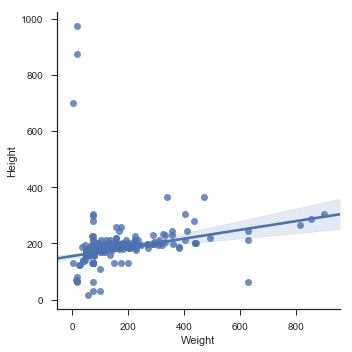

In [161]:
sns.lmplot('Weight','Height',heros_info)

Welp, the pattern seems pretty clear after this linear regression.